# Polynomial Regression, Overfitting and Regularisation

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Create small sample

<Axes: xlabel='BMI', ylabel='BodyFat'>

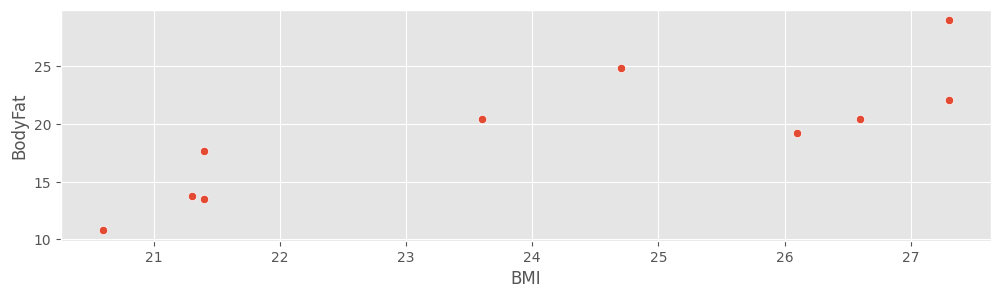

In [3]:
data = pd.read_csv("bodyfat.csv")
data_simple = data[data.BMI<35] # remove outliers to avoid using a robust model
data_10points = data_simple.sample(10, random_state=3)
sns.scatterplot( data=data_10points, x="BMI", y="BodyFat" )

## Fit a linear model

In [4]:
linear_model = bmb.Model("BodyFat ~ BMI", data_10points, family="gaussian")
linear_trace = linear_model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


## Fit a polynomial model

In [5]:
poly_model = bmb.Model("BodyFat ~ BMI + I(BMI**2) + I(BMI**3)", data_10points, family="gaussian")
poly_trace = poly_model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI, I(BMI ** 2), I(BMI ** 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.


Slow and full of divergences! Better use orthogonal polynomes using the `poly()` function:

In [6]:
poly_model = bmb.Model("BodyFat ~ poly( BMI, 3 )", data_10points, family="gaussian")
poly_trace = poly_model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(BMI, 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


## Compare models

Default computed for conditional variable: BMI
Default computed for conditional variable: BMI


Text(0.5, 1.0, 'BodyFat ~ poly(BMI, 3)')

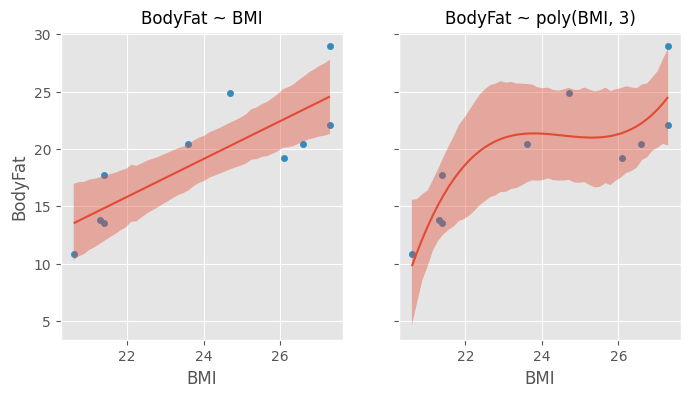

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8,4) )
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[0] )
bmb.interpret.plot_predictions( linear_model, linear_trace, "BMI", prob=0.9, ax=ax[0] )
ax[0].set_title("BodyFat ~ BMI", fontsize=12)
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[1] )
bmb.interpret.plot_predictions( poly_model, poly_trace, "BMI", prob=0.9, ax=ax[1] )
ax[1].set_title("BodyFat ~ poly(BMI, 3)", fontsize=12)

The polynomial model is clearly overfitting to the noise in the data points.

## Regularisation

Look at the model:

In [8]:
poly_model

       Formula: BodyFat ~ poly( BMI, 3 )
        Family: gaussian
          Link: mu = identity
  Observations: 10
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 19.18, sigma: 13.0928)
            poly(BMI, 3) ~ Normal(mu: [0. 0. 0.], sigma: [41.4032 41.4032 41.4032])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2371)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Weak priors used for all coefficients! Instead shrink the higher order coefficients towards zero with stronger priors:

In [9]:
priors = {
    "poly(BMI, 3)": bmb.Prior("Normal", mu=[0,0,0], sigma=[41.4,1,1]),
}

poly_model2 = bmb.Model("BodyFat ~ poly(BMI, 3)", data_10points, priors=priors, family="gaussian")
poly_trace2 = poly_model2.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(BMI, 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


Default computed for conditional variable: BMI
Default computed for conditional variable: BMI


Text(0.5, 1.0, '$\\sigma$ = [41.4, 1, 1] (strong)')

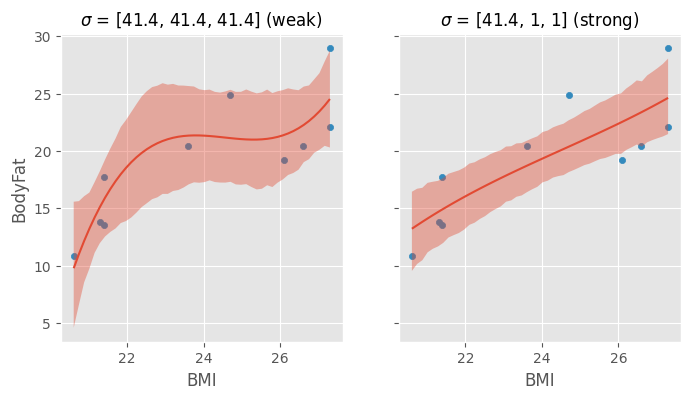

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8,4) )
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[0] )
bmb.interpret.plot_predictions( poly_model, poly_trace, "BMI", prob=0.9, ax=ax[0] )
ax[0].set_title("$\sigma$ = [41.4, 41.4, 41.4] (weak)", fontsize=12)
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[1] )
bmb.interpret.plot_predictions( poly_model2, poly_trace2, "BMI", prob=0.9, ax=ax[1] )
ax[1].set_title("$\sigma$ = [41.4, 1, 1] (strong)", fontsize=12)

The model with stronger priors is almost linear!